In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# import warnings
# warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

## В этом ноутбуке будем отбирать самые важные фичи из тех что нам удалось собрать и посмотрим на то есть ли полиномиальные или нелинейные зависимости между фичей и таргетом

### Подготовка и нормировка данных

In [39]:
df_overpass_1 = pd.read_csv('../../checkpoint-2/overpass/adj_df_additional.csv',index_col=[0])
df_overpass_2 = pd.read_csv('../../checkpoint-2/overpass/adj_df.csv',index_col=[0])
df_overpass = df_overpass_1.merge(df_overpass_2, on = 'id')
df_info = pd.read_csv('../../checkpoint-2/overpass/concat_df.csv',index_col=[0])
df = df_info.merge(df_overpass, on = ['id'])

meaningful_subset = set(df.columns).difference(['id', 'long', 'lat', 'utm',
                                                'geometry', 'address', 'address_rus'])

train = df[~df.target.isna()][meaningful_subset]
test = df[df.target.isna()][meaningful_subset].drop(columns = ['target'])

enc = OneHotEncoder(handle_unknown='ignore',drop = 'first')
enc.fit(train.atm_group.to_numpy().reshape(-1, 1))
train[enc.get_feature_names_out(['atm_group'])] = pd.DataFrame(enc.transform(train.atm_group.to_numpy().reshape(-1, 1)).toarray())
test[enc.get_feature_names_out(['atm_group'])] = pd.DataFrame(enc.transform(test.atm_group.to_numpy().reshape(-1, 1)).toarray())

train = train.drop(columns=['atm_group'])
test = test.drop(columns=['atm_group'])

X_train, X_test, y_train, y_test = train_test_split(train.drop(columns = ['target']),train.target , test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)
test = pd.DataFrame(scaler.transform(test),columns = test.columns)



/var/folders/8m/fpt3kb2n0ys89v3nl34fszrd2jtv8f/T/ipykernel_2229/2076267863.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train = df[~df.target.isna()][meaningful_subset]
/var/folders/8m/fpt3kb2n0ys89v3nl34fszrd2jtv8f/T/ipykernel_2229/2076267863.py:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  test = df[df.target.isna()][meaningful_subset].drop(columns = ['target'])


### Посмотрим на ковариации и pairplot

In [40]:
corrs = X_train.apply(lambda x: x.corr(y_train))
order = corrs.abs().sort_values(ascending = False)
corrs_ordered = corrs[order.index]

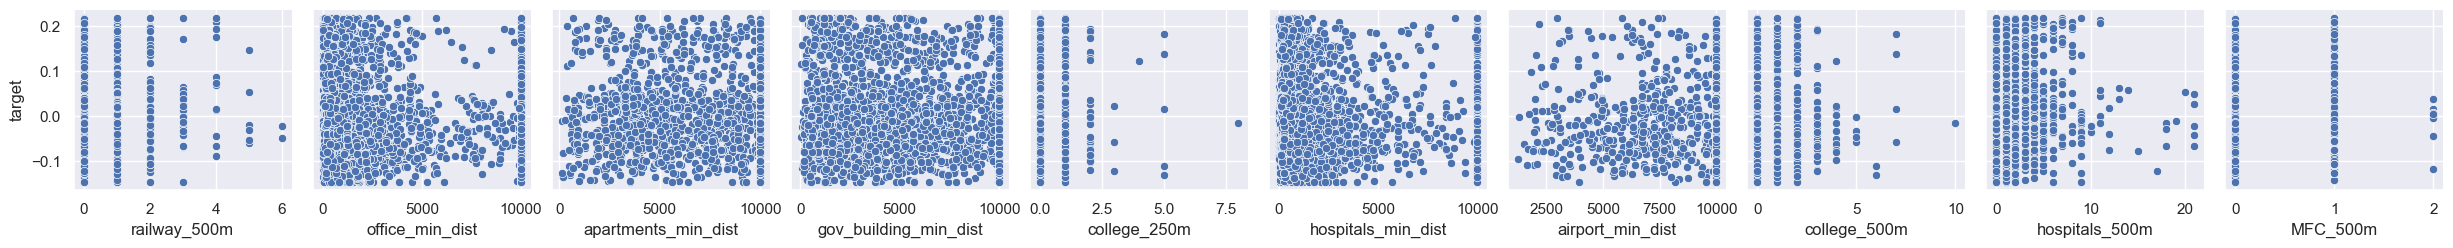

In [41]:
pp = sns.pairplot(data=train,
                  y_vars=['target'],
                  x_vars=list(X_train)[:10])


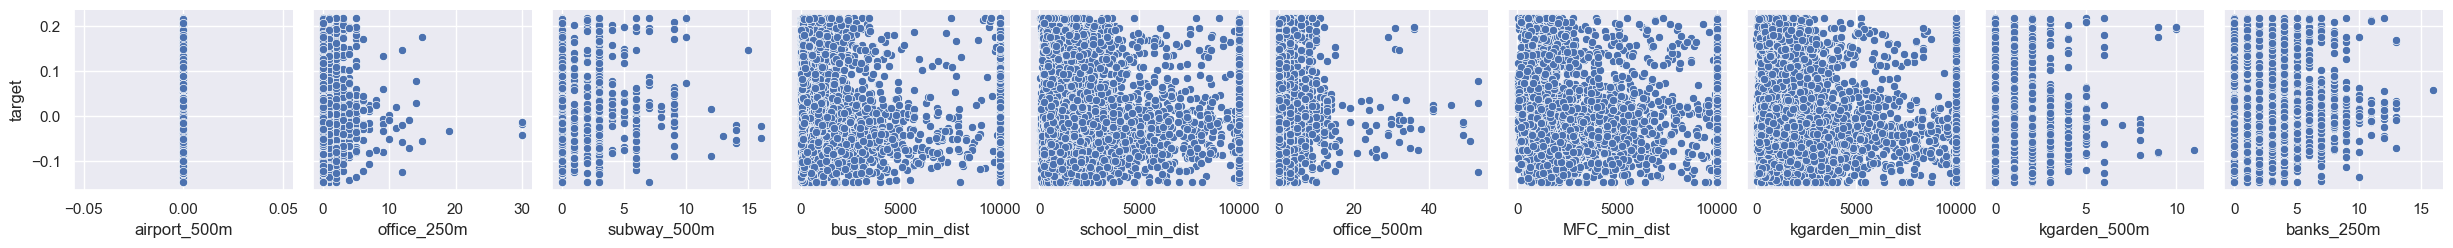

In [42]:
pp = sns.pairplot(data=train,
                  y_vars=['target'],
                  x_vars=list(X_train)[10:20])

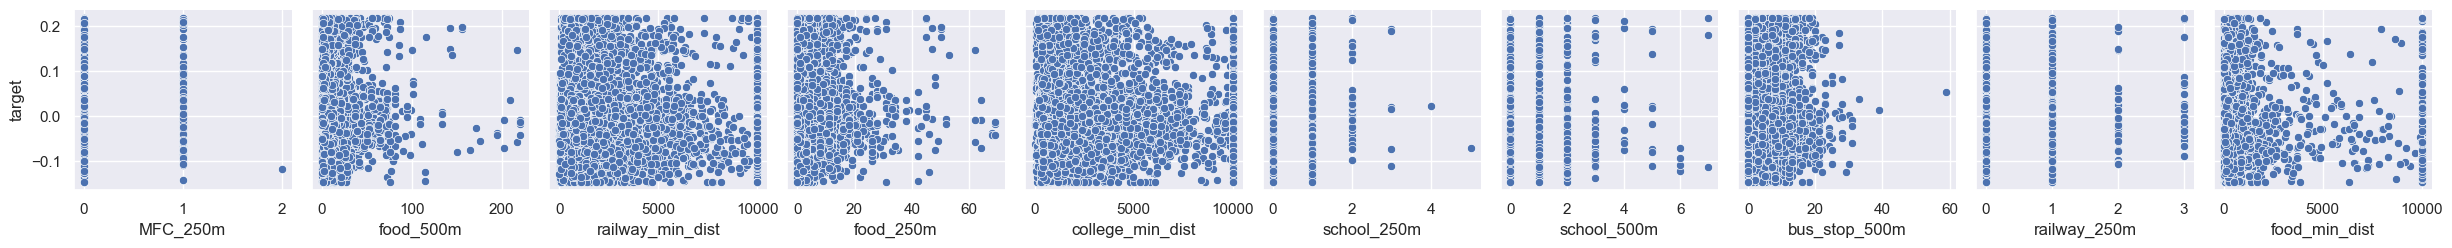

In [43]:
pp = sns.pairplot(data=train,
                  y_vars=['target'],
                  x_vars=list(X_train)[20:30])

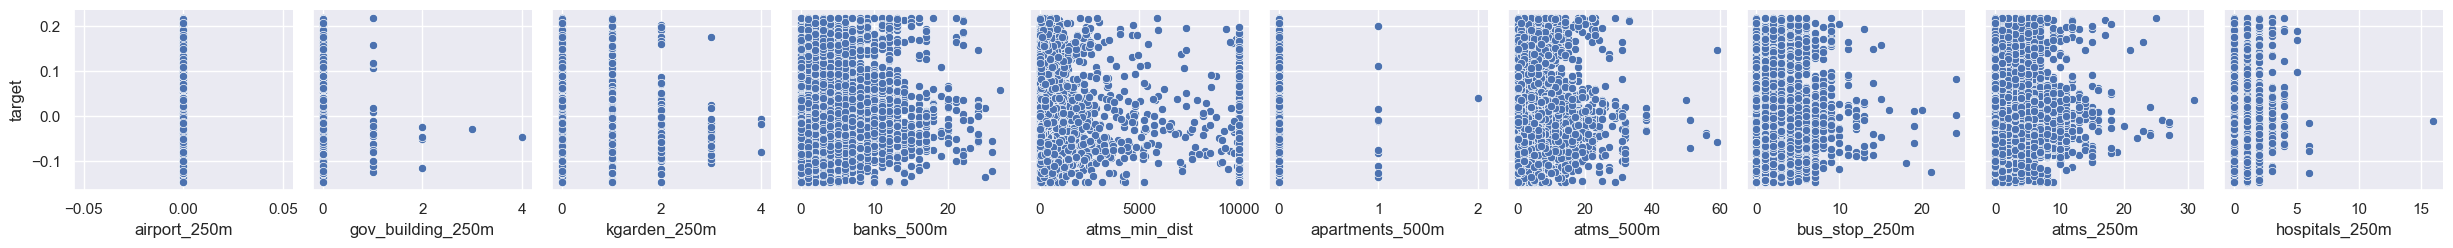

In [44]:
pp = sns.pairplot(data=train,
                  y_vars=['target'],
                  x_vars=list(X_train)[30:40])

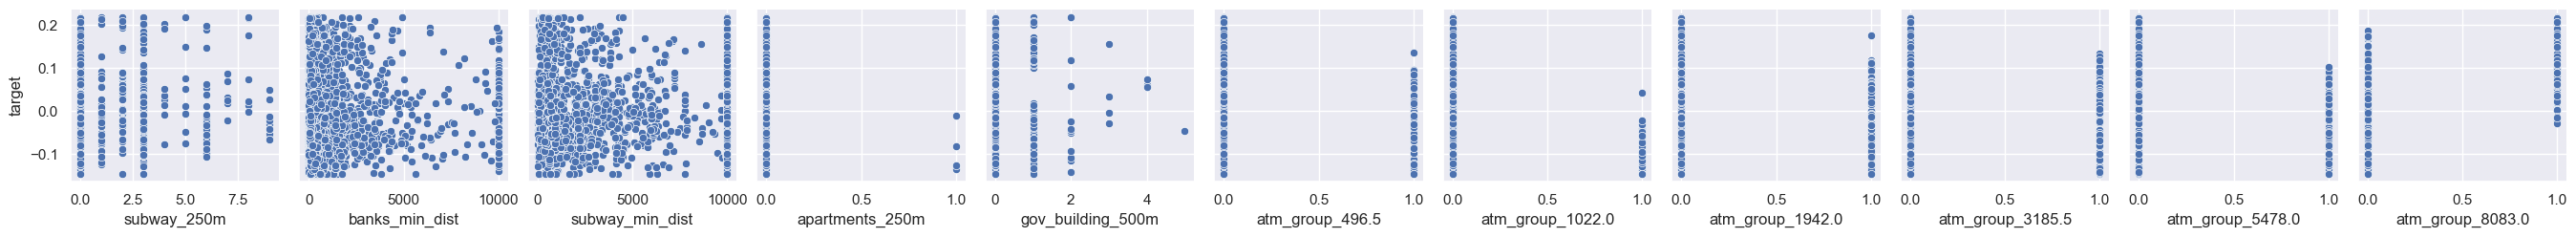

In [45]:
pp = sns.pairplot(data=train,
                  y_vars=['target'],
                  x_vars=list(X_train)[40:])

In [46]:
corrs_ordered

atms_250m               -0.034509
atms_500m               -0.029272
atm_group_8083.0        -0.028367
banks_250m              -0.025872
hospitals_250m          -0.025080
apartments_min_dist      0.024104
banks_500m              -0.022792
gov_building_250m        0.022693
college_250m             0.021053
college_min_dist        -0.020395
atm_group_3185.5         0.019048
kgarden_500m            -0.018056
railway_min_dist        -0.017319
bus_stop_min_dist       -0.016570
MFC_250m                -0.016189
subway_250m              0.014878
office_min_dist          0.014379
college_500m             0.014298
banks_min_dist          -0.014121
kgarden_min_dist        -0.013688
atm_group_1942.0         0.013531
hospitals_500m          -0.013391
school_250m             -0.013179
apartments_500m         -0.013139
school_500m             -0.012960
railway_250m             0.012912
MFC_500m                -0.012159
kgarden_250m            -0.011390
atm_group_496.5          0.009030
atm_group_5478

In [59]:
selected_columns = corrs_ordered[corrs_ordered.abs()>0.01].index.to_list()
selected_columns = [*filter(lambda x: '_500m' not in x,selected_columns)]

#### Особо нелинейных зависимостей в таргетом (или каких-то зависимостей) на графике не видно. Для использования на других моделях будем использовать фичи с корреляцией больше 0.01 (почему? Потому что я так чувствую) и удалим 500м так как оно сильно коррелирует с 250м

In [60]:
X_train[selected_columns]

,atms_250m,atm_group_8083.0,banks_250m,hospitals_250m,apartments_min_dist,gov_building_250m,college_250m,college_min_dist,atm_group_3185.5,railway_min_dist,bus_stop_min_dist,MFC_250m,subway_250m,office_min_dist,banks_min_dist,kgarden_min_dist,atm_group_1942.0,school_250m,railway_250m,kgarden_250m
0,-0.658183,-0.445467,-0.724842,1.230279,0.395139,-0.060125,-0.155171,1.724306,-0.318159,-0.202848,-0.055831,-0.135609,-0.211546,2.732198,0.977653,2.491740,-0.473610,-0.232191,-0.271419,-0.259480
1,0.689434,-0.445467,-0.724842,1.230279,0.395139,-0.060125,-0.155171,1.163737,-0.318159,-0.522124,-0.539720,-0.135609,-0.211546,-0.276655,-0.151341,-0.507439,-0.473610,-0.232191,-0.271419,-0.259480
2,-0.321279,2.244836,-0.724842,-0.417354,0.395139,-0.060125,-0.155171,0.172300,-0.318159,-0.818787,0.100271,-0.135609,-0.211546,-0.291846,-0.178851,-0.738886,-0.473610,-0.232191,-0.271419,-0.259480
3,-0.658183,-0.445467,-0.724842,-0.417354,0.395139,-0.060125,-0.155171,-0.056889,-0.318159,2.675394,2.868022,-0.135609,-0.211546,-0.577167,-0.234711,-0.478112,-0.473610,-0.232191,-0.271419,-0.259480
4,-0.658183,2.244836,-0.252937,-0.417354,-2.685868,-0.060125,-0.155171,0.007010,-0.318159,0.381728,-0.493772,-0.135609,-0.211546,-0.484782,-0.278678,-0.738331,-0.473610,-0.232191,-0.271419,-0.259480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4760,-0.658183,-0.445467,-0.724842,-0.417354,0.395139,-0.060125,-0.155171,1.720357,-0.318159,1.332596,-0.541233,-0.135609,-0.211546,2.213351,5.345353,0.308552,2.111443,-0.232191,-0.271419,-0.259480
4761,-0.658183,-0.445467,-0.724842,-0.417354,0.395139,-0.060125,-0.155171,1.724306,3.143087,-0.203760,0.197211,-0.135609,-0.211546,0.118353,-0.246234,-0.777585,-0.473610,3.161642,-0.271419,2.544201
4762,0.015626,-0.445467,-0.724842,-0.417354,0.395139,-0.060125,-0.155171,-0.296367,3.143087,0.314585,-0.537823,-0.135609,-0.211546,-0.354085,-0.133038,-0.321894,-0.473610,-0.232191,-0.271419,-0.259480
4763,-0.321279,-0.445467,-0.724842,-0.417354,0.395139,-0.060125,-0.155171,0.703099,-0.318159,-0.249444,-0.544033,-0.135609,-0.211546,-0.389833,-0.107843,1.334198,-0.473610,-0.232191,-0.271419,-0.259480


In [61]:
corr = X_train[selected_columns].corr()
corr.style.background_gradient(cmap='coolwarm')

,atms_250m,atm_group_8083.0,banks_250m,hospitals_250m,apartments_min_dist,gov_building_250m,college_250m,college_min_dist,atm_group_3185.5,railway_min_dist,bus_stop_min_dist,MFC_250m,subway_250m,office_min_dist,banks_min_dist,kgarden_min_dist,atm_group_1942.0,school_250m,railway_250m,kgarden_250m
atms_250m,1.000000,-0.007876,0.487285,0.113114,-0.139898,0.018402,0.049887,-0.237960,-0.045197,-0.193586,-0.201549,0.033269,0.344134,-0.235926,-0.184921,-0.223103,0.198399,0.086413,0.306040,0.057577
atm_group_8083.0,-0.007876,1.000000,0.004557,0.055947,-0.013599,0.001105,0.037072,-0.017670,-0.141729,0.030209,0.048515,0.005923,-0.011373,-0.035379,0.013606,-0.015781,-0.210977,0.005787,-0.029633,-0.017447
banks_250m,0.487285,0.004557,1.000000,0.260599,-0.160412,0.046430,0.066094,-0.282813,-0.069848,-0.236115,-0.200599,0.044965,0.301980,-0.230738,-0.268676,-0.235111,0.190237,0.167136,0.227682,0.142338
hospitals_250m,0.113114,0.055947,0.260599,1.000000,-0.037673,0.002235,0.049615,-0.172310,-0.028661,-0.108557,-0.111914,-0.003278,0.165845,-0.146787,-0.115173,-0.147350,0.046359,0.087336,0.143665,0.119526
apartments_min_dist,-0.139898,-0.013599,-0.160412,-0.037673,1.000000,0.017189,-0.060940,0.165145,-0.025603,0.146416,0.135612,-0.011611,-0.046798,0.167799,0.095447,0.156431,-0.085747,-0.057673,-0.022164,-0.066181
gov_building_250m,0.018402,0.001105,0.046430,0.002235,0.017189,1.000000,0.010841,-0.031459,-0.019129,-0.012954,-0.030819,0.022294,0.015586,-0.020329,-0.003896,-0.022034,0.014400,0.007149,0.018962,0.019275
college_250m,0.049887,0.037072,0.066094,0.049615,-0.060940,0.010841,1.000000,-0.158903,-0.009323,-0.051073,-0.054478,0.018937,-0.015791,-0.057597,-0.049882,-0.060743,0.002160,0.072529,-0.013163,0.005531
college_min_dist,-0.237960,-0.017670,-0.282813,-0.172310,0.165145,-0.031459,-0.158903,1.000000,-0.027499,0.325754,0.412868,-0.023321,-0.144027,0.499692,0.344827,0.512715,-0.142088,-0.090187,-0.114951,-0.085078
atm_group_3185.5,-0.045197,-0.141729,-0.069848,-0.028661,-0.025603,-0.019129,-0.009323,-0.027499,1.000000,0.048131,0.012268,-0.011142,-0.032595,-0.042414,0.009552,-0.040866,-0.150683,-0.007312,-0.036910,-0.009240
railway_min_dist,-0.193586,0.030209,-0.236115,-0.108557,0.146416,-0.012954,-0.051073,0.325754,0.048131,1.000000,0.512408,-0.025115,-0.204974,0.252495,0.318059,0.244021,-0.133467,-0.057907,-0.264427,-0.046783


In [62]:
X_train[selected_columns].to_csv('../X_train_transformed_reduced.csv')
y_train.to_csv('../y_train_transformed_reduced.csv')
X_test[selected_columns].to_csv('../X_test_transformed_reduced.csv')
y_test.to_csv('../y_test_transformed_reduced.csv')
test[selected_columns].to_csv('../test_transformed_reduced.csv')

In [63]:
X_train.to_csv('../X_train_transformed.csv')
y_train.to_csv('../y_train_transformed.csv')
X_test.to_csv('../X_test_transformed.csv')
y_test.to_csv('../y_test_transformed.csv')
test.to_csv('../test_transformed.csv')